
# MMF1921/MIE377 - Backtesting Template

The purpose of this program is to provide a template with which to develop Project 2. The project requires you to test different models  (and/or different model combinations) to create an asset management algorithm.

This template will be used by the instructor and TA to assess your trading algorithm using different datasets.

# PLEASE DO NOT MODIFY THIS TEMPLATE (for Project submission purposes)

# 1. Read input files

In [1]:
import time
import math
from scipy.stats import gmean
import matplotlib.pyplot as plt
from services.project_function import *
import pandas as pd


# 1. Varying L

In [9]:
ps = []
times = []
sharpes = []
turnovers = []

L = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3]

for i in range(0,8):

    U = 1
    K = 10

    adjClose = pd.read_csv("MIE377_AssetPrices.csv", index_col=0)
    factorRet = pd.read_csv("MIE377_FactorReturns.csv", index_col=0)

    adjClose.index = pd.to_datetime(adjClose.index)
    factorRet.index = pd.to_datetime(factorRet.index)

    # Initial budget to invest ($100,000)
    initialVal = 100000

    # Length of investment period (in months)
    investPeriod = 6

    # divide the factor returns by  100
    factorRet = factorRet/100

    #rf and factor returns
    riskFree = factorRet['RF']
    factorRet = factorRet.loc[:,factorRet.columns != 'RF'];

    #Identify the tickers and the dates
    tickers = adjClose.columns
    dates   = factorRet.index

    # Calculate the stocks monthly excess returns
    # pct change and drop the first null observation
    returns = adjClose.pct_change(1).iloc[1:, :]


    returns = returns  - np.diag(riskFree.values) @ np.ones_like(returns.values)
    # Align the price table to the asset and factor returns tables by discarding the first observation.
    adjClose = adjClose.iloc[1:,:]

    assert adjClose.index[0] == returns.index[0]
    assert adjClose.index[0] == factorRet.index[0]

    # Start of out-of-sample test period
    testStart = returns.index[0] + pd.offsets.DateOffset(years=5)

    #End of the first investment period
    testEnd = testStart + pd.offsets.DateOffset(months=investPeriod) -  pd.offsets.DateOffset(days = 1)

    # End of calibration period
    calEnd = testStart -  pd.offsets.DateOffset(days = 1)

    # Total number of investment periods
    NoPeriods = math.ceil((returns.index[-1].to_period('M') - testStart.to_period('M')).n / investPeriod)

    # Number of assets
    n  = len(tickers)

    # Preallocate space for the portfolio weights (x0 will be used to calculate
    # the turnover rate)
    x  = np.zeros([n, NoPeriods])
    x0 = np.zeros([n, NoPeriods])

    # Preallocate space for the portfolio per period value and turnover
    currentVal = np.zeros([NoPeriods, 1])
    turnover   = np.zeros([NoPeriods, 1])

    #Initiate counter for the number of observations per investment period
    toDay = 0

    # Measure runtime: start the clock
    start_time = time.time()

    # Empty list to measure the value of the portfolio over the period
    portfValue = []

    for t in range(NoPeriods):
        # Subset the returns and factor returns corresponding to the current calibration period.
        periodReturns = returns[returns.index <= calEnd]
        periodFactRet = factorRet[factorRet.index <= calEnd]

        current_price_idx = (calEnd - pd.offsets.DateOffset(months=1) <= adjClose.index)&(adjClose.index <= calEnd)
        currentPrices = adjClose[current_price_idx]

        # Subset the prices corresponding to the current out-of-sample test period.
        periodPrices_idx = (testStart <= adjClose.index)&(adjClose.index <= testEnd)
        periodPrices = adjClose[periodPrices_idx]

        assert len(periodPrices) == investPeriod
        assert len(currentPrices) == 1
        # Set the initial value of the portfolio or update the portfolio value
        if t == 0:
            currentVal[0] = initialVal
        else:
            currentVal[t] = currentPrices @  NoShares.values.T
            #Store the current asset weights (before optimization takes place)
            x0[:,t] = currentPrices.values*NoShares.values/currentVal[t]

        #----------------------------------------------------------------------
        # Portfolio optimization
        # You must write code your own algorithmic trading function
        #----------------------------------------------------------------------
        x[:,t] = project_function(periodReturns, periodFactRet, x0[:,t], L[i], U,K)

        #Calculate the turnover rate
        if t > 0:
            turnover[t] = np.sum( np.abs( x[:,t] - x0[:,t] ) )

        # Number of shares your portfolio holds per stock
        NoShares = x[:,t]*currentVal[t]/currentPrices

        # Update counter for the number of observations per investment period
        fromDay = toDay
        toDay   = toDay + len(periodPrices)

        # Weekly portfolio value during the out-of-sample window
        portfValue.append(periodPrices@ NoShares.values.T)

        # Update your calibration and out-of-sample test periods
        testStart = testStart + pd.offsets.DateOffset(months=investPeriod)
        testEnd   = testStart + pd.offsets.DateOffset(months=investPeriod) - pd.offsets.DateOffset(days=1)
        calEnd    = testStart - pd.offsets.DateOffset(days=1)

    portfValue = pd.concat(portfValue, axis = 0)
    end_time = time.time()

    #--------------------------------------------------------------------------
    # 3.1 Calculate the portfolio average return, standard deviation, Sharpe ratio and average turnover.
    #-----------------------------------------------------------------------
    # Calculate the observed portfolio returns
    portfRets = portfValue.pct_change(1).iloc[1:,:]

    # Calculate the portfolio excess returns
    portfExRets = portfRets.subtract(riskFree[(riskFree.index >= portfRets.index[0])&(riskFree.index <= portfRets.index[-1])], axis = 0)

    # Calculate the portfolio Sharpe ratio
    SR = ((portfExRets + 1).apply(gmean, axis=0) - 1)/portfExRets.std()

    # Calculate the average turnover rate
    avgTurnover = np.mean(turnover[1:])

    #Print Sharpe ratio and Avg. turnover to the console
    print(L[i])
    print("Elasped time is "+ str(end_time - start_time) + ' seconds')
    print('Sharpe ratio: ', str(SR[0]))
    print('Avg. turnover: ', str(avgTurnover))
    print('\n')

    #ps.append(p)
    times.append(end_time - start_time)
    sharpes.append(SR[0])
    turnovers.append(avgTurnover)

0.01
Elasped time is 0.982213020324707 seconds
Sharpe ratio:  0.18584036708867824
Avg. turnover:  0.4842311734332133


0.02
Elasped time is 0.7603850364685059 seconds
Sharpe ratio:  0.18373718700882252
Avg. turnover:  0.48563412477123624


0.03
Elasped time is 0.7983098030090332 seconds
Sharpe ratio:  0.1863729875868963
Avg. turnover:  0.4845395971127029


0.04
Elasped time is 0.7434122562408447 seconds
Sharpe ratio:  0.19010546270557496
Avg. turnover:  0.506974334580198


0.05
Elasped time is 0.9338200092315674 seconds
Sharpe ratio:  0.19275449850346185
Avg. turnover:  0.5068040623551566


0.1
Elasped time is 0.9817500114440918 seconds
Sharpe ratio:  0.17143850998150126
Avg. turnover:  0.5548816780682299


0.2
Elasped time is 1.1211609840393066 seconds
Sharpe ratio:  0.17816103139956957
Avg. turnover:  0.6902170271919235


0.3
Elasped time is 1.1791391372680664 seconds
Sharpe ratio:  0.15399341153090043
Avg. turnover:  0.8734552805718905




In [10]:
df = pd.DataFrame({'L': L, 'Time': times, 'Sharpe Ratio': sharpes, 'Turnover': turnovers},
                  index=L)
df

,L,Time,Sharpe Ratio,Turnover
0.01,0.01,0.982213,0.185840,0.484231
0.02,0.02,0.760385,0.183737,0.485634
0.03,0.03,0.798310,0.186373,0.484540
0.04,0.04,0.743412,0.190105,0.506974
0.05,0.05,0.933820,0.192754,0.506804
0.10,0.10,0.981750,0.171439,0.554882
0.20,0.20,1.121161,0.178161,0.690217
0.30,0.30,1.179139,0.153993,0.873455


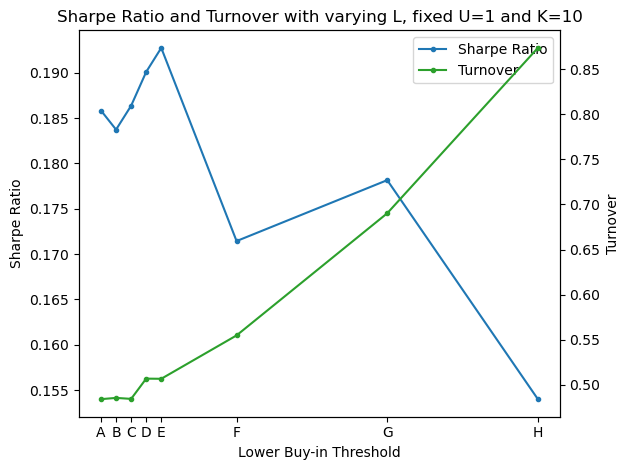

In [20]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

plt.title('Sharpe Ratio and Turnover with varying L, fixed U=1 and K=10')

ax1.plot(df['L'].values, df['Sharpe Ratio'].values, label='Sharpe Ratio', marker='.', color='tab:blue')
ax1.plot([], [], label='Turnover', marker='.', color='tab:green')
ax2.plot(df['L'].values, df['Turnover'].values, label='Turnover', marker='.', color='tab:green')
ax1.set_xlabel('Lower Buy-in Threshold')
ax1.set_ylabel('Sharpe Ratio')
ax2.set_ylabel('Turnover')

ax1.legend()
#plt.xticks(range(0, 0.3))
plt.xticks(L, ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'])
#plt.legend(['A = 0.01', 'B=0.02', 'C=0.03', 'D=0.04', 'E=0.05', 'F=0.1', 'G=0.2', 'H=0.3'])
plt.tight_layout()
plt.show()


# 2. Varying U

In [36]:
K = []
times = []
sharpes = []
turnovers = []

for i in range(1,21):

    L = 0.03
    U = 1

    adjClose = pd.read_csv("MIE377_AssetPrices.csv", index_col=0)
    factorRet = pd.read_csv("MIE377_FactorReturns.csv", index_col=0)

    adjClose.index = pd.to_datetime(adjClose.index)
    factorRet.index = pd.to_datetime(factorRet.index)

    # Initial budget to invest ($100,000)
    initialVal = 100000

    # Length of investment period (in months)
    investPeriod = 6

    # divide the factor returns by  100
    factorRet = factorRet/100

    #rf and factor returns
    riskFree = factorRet['RF']
    factorRet = factorRet.loc[:,factorRet.columns != 'RF'];

    #Identify the tickers and the dates
    tickers = adjClose.columns
    dates   = factorRet.index

    # Calculate the stocks monthly excess returns
    # pct change and drop the first null observation
    returns = adjClose.pct_change(1).iloc[1:, :]


    returns = returns  - np.diag(riskFree.values) @ np.ones_like(returns.values)
    # Align the price table to the asset and factor returns tables by discarding the first observation.
    adjClose = adjClose.iloc[1:,:]

    assert adjClose.index[0] == returns.index[0]
    assert adjClose.index[0] == factorRet.index[0]

    # Start of out-of-sample test period
    testStart = returns.index[0] + pd.offsets.DateOffset(years=5)

    #End of the first investment period
    testEnd = testStart + pd.offsets.DateOffset(months=investPeriod) -  pd.offsets.DateOffset(days = 1)

    # End of calibration period
    calEnd = testStart -  pd.offsets.DateOffset(days = 1)

    # Total number of investment periods
    NoPeriods = math.ceil((returns.index[-1].to_period('M') - testStart.to_period('M')).n / investPeriod)

    # Number of assets
    n  = len(tickers)

    # Preallocate space for the portfolio weights (x0 will be used to calculate
    # the turnover rate)
    x  = np.zeros([n, NoPeriods])
    x0 = np.zeros([n, NoPeriods])

    # Preallocate space for the portfolio per period value and turnover
    currentVal = np.zeros([NoPeriods, 1])
    turnover   = np.zeros([NoPeriods, 1])

    #Initiate counter for the number of observations per investment period
    toDay = 0

    # Measure runtime: start the clock
    start_time = time.time()

    # Empty list to measure the value of the portfolio over the period
    portfValue = []

    for t in range(NoPeriods):
        # Subset the returns and factor returns corresponding to the current calibration period.
        periodReturns = returns[returns.index <= calEnd]
        periodFactRet = factorRet[factorRet.index <= calEnd]

        current_price_idx = (calEnd - pd.offsets.DateOffset(months=1) <= adjClose.index)&(adjClose.index <= calEnd)
        currentPrices = adjClose[current_price_idx]

        # Subset the prices corresponding to the current out-of-sample test period.
        periodPrices_idx = (testStart <= adjClose.index)&(adjClose.index <= testEnd)
        periodPrices = adjClose[periodPrices_idx]

        assert len(periodPrices) == investPeriod
        assert len(currentPrices) == 1
        # Set the initial value of the portfolio or update the portfolio value
        if t == 0:
            currentVal[0] = initialVal
        else:
            currentVal[t] = currentPrices @  NoShares.values.T
            #Store the current asset weights (before optimization takes place)
            x0[:,t] = currentPrices.values*NoShares.values/currentVal[t]

        #----------------------------------------------------------------------
        # Portfolio optimization
        # You must write code your own algorithmic trading function
        #----------------------------------------------------------------------
        x[:,t] = project_function(periodReturns, periodFactRet, x0[:,t], L, U, i)

        #Calculate the turnover rate
        if t > 0:
            turnover[t] = np.sum( np.abs( x[:,t] - x0[:,t] ) )

        # Number of shares your portfolio holds per stock
        NoShares = x[:,t]*currentVal[t]/currentPrices

        # Update counter for the number of observations per investment period
        fromDay = toDay
        toDay   = toDay + len(periodPrices)

        # Weekly portfolio value during the out-of-sample window
        portfValue.append(periodPrices@ NoShares.values.T)

        # Update your calibration and out-of-sample test periods
        testStart = testStart + pd.offsets.DateOffset(months=investPeriod)
        testEnd   = testStart + pd.offsets.DateOffset(months=investPeriod) - pd.offsets.DateOffset(days=1)
        calEnd    = testStart - pd.offsets.DateOffset(days=1)

    portfValue = pd.concat(portfValue, axis = 0)
    end_time = time.time()

    #--------------------------------------------------------------------------
    # 3.1 Calculate the portfolio average return, standard deviation, Sharpe ratio and average turnover.
    #-----------------------------------------------------------------------
    # Calculate the observed portfolio returns
    portfRets = portfValue.pct_change(1).iloc[1:,:]

    # Calculate the portfolio excess returns
    portfExRets = portfRets.subtract(riskFree[(riskFree.index >= portfRets.index[0])&(riskFree.index <= portfRets.index[-1])], axis = 0)

    # Calculate the portfolio Sharpe ratio
    SR = ((portfExRets + 1).apply(gmean, axis=0) - 1)/portfExRets.std()

    # Calculate the average turnover rate
    avgTurnover = np.mean(turnover[1:])

    #Print Sharpe ratio and Avg. turnover to the console
    print(i)
    print("Elasped time is "+ str(end_time - start_time) + ' seconds')
    print('Sharpe ratio: ', str(SR[0]))
    print('Avg. turnover: ', str(avgTurnover))
    print('\n')

    K.append(i)
    times.append(end_time - start_time)
    sharpes.append(SR[0])
    turnovers.append(avgTurnover)

1
Elasped time is 0.7006330490112305 seconds
Sharpe ratio:  0.08796328264768127
Avg. turnover:  1.4736842105263157


2
Elasped time is 1.8563790321350098 seconds
Sharpe ratio:  0.17838845368887557
Avg. turnover:  1.019251754624164


3
Elasped time is 1.955901861190796 seconds
Sharpe ratio:  0.16445810015572007
Avg. turnover:  0.6805069626781011


4
Elasped time is 1.888976812362671 seconds
Sharpe ratio:  0.18262772028584856
Avg. turnover:  0.5843703898323075


5
Elasped time is 1.7164709568023682 seconds
Sharpe ratio:  0.17529789673556737
Avg. turnover:  0.6010673460908952


6
Elasped time is 1.3660857677459717 seconds
Sharpe ratio:  0.1805207252467705
Avg. turnover:  0.6480221061489577


7
Elasped time is 1.0581350326538086 seconds
Sharpe ratio:  0.18608946154423095
Avg. turnover:  0.5692750894791448


8
Elasped time is 0.9895570278167725 seconds
Sharpe ratio:  0.18296685309374888
Avg. turnover:  0.5090256686619739


9
Elasped time is 0.7682669162750244 seconds
Sharpe ratio:  0.190495

In [37]:
df = pd.DataFrame({'K': K, 'Time': times, 'Sharpe Ratio': sharpes, 'Turnover': turnovers},
                  index=K)
df

,K,Time,Sharpe Ratio,Turnover
1,1,0.700633,0.087963,1.473684
2,2,1.856379,0.178388,1.019252
3,3,1.955902,0.164458,0.680507
4,4,1.888977,0.182628,0.584370
5,5,1.716471,0.175298,0.601067
6,6,1.366086,0.180521,0.648022
7,7,1.058135,0.186089,0.569275
8,8,0.989557,0.182967,0.509026
9,9,0.768267,0.190495,0.495357
10,10,0.688177,0.186373,0.484540


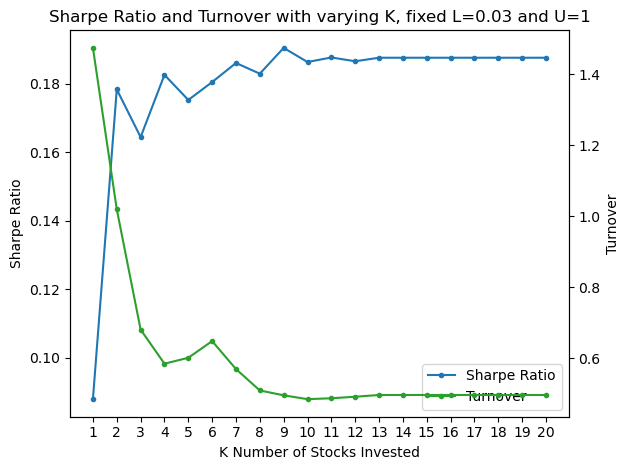

In [38]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

plt.title('Sharpe Ratio and Turnover with varying K, fixed L=0.03 and U=1')

ax1.plot(df['K'].values, df['Sharpe Ratio'].values, label='Sharpe Ratio', marker='.', color='tab:blue')
ax1.plot([], [], label='Turnover', marker='.', color='tab:green')
ax2.plot(df['K'].values, df['Turnover'].values, label='Turnover', marker='.', color='tab:green')
ax1.set_xlabel('K Number of Stocks Invested')
ax1.set_ylabel('Sharpe Ratio')
ax2.set_ylabel('Turnover')

ax1.legend()
plt.xticks(range(1, 21))
plt.tight_layout()
plt.show()

In [39]:
K = []
times = []
sharpes = []
turnovers = []

for i in range(1,21):

    L = 0.05
    U = 1

    adjClose = pd.read_csv("MIE377_AssetPrices.csv", index_col=0)
    factorRet = pd.read_csv("MIE377_FactorReturns.csv", index_col=0)

    adjClose.index = pd.to_datetime(adjClose.index)
    factorRet.index = pd.to_datetime(factorRet.index)

    # Initial budget to invest ($100,000)
    initialVal = 100000

    # Length of investment period (in months)
    investPeriod = 6

    # divide the factor returns by  100
    factorRet = factorRet/100

    #rf and factor returns
    riskFree = factorRet['RF']
    factorRet = factorRet.loc[:,factorRet.columns != 'RF'];

    #Identify the tickers and the dates
    tickers = adjClose.columns
    dates   = factorRet.index

    # Calculate the stocks monthly excess returns
    # pct change and drop the first null observation
    returns = adjClose.pct_change(1).iloc[1:, :]


    returns = returns  - np.diag(riskFree.values) @ np.ones_like(returns.values)
    # Align the price table to the asset and factor returns tables by discarding the first observation.
    adjClose = adjClose.iloc[1:,:]

    assert adjClose.index[0] == returns.index[0]
    assert adjClose.index[0] == factorRet.index[0]

    # Start of out-of-sample test period
    testStart = returns.index[0] + pd.offsets.DateOffset(years=5)

    #End of the first investment period
    testEnd = testStart + pd.offsets.DateOffset(months=investPeriod) -  pd.offsets.DateOffset(days = 1)

    # End of calibration period
    calEnd = testStart -  pd.offsets.DateOffset(days = 1)

    # Total number of investment periods
    NoPeriods = math.ceil((returns.index[-1].to_period('M') - testStart.to_period('M')).n / investPeriod)

    # Number of assets
    n  = len(tickers)

    # Preallocate space for the portfolio weights (x0 will be used to calculate
    # the turnover rate)
    x  = np.zeros([n, NoPeriods])
    x0 = np.zeros([n, NoPeriods])

    # Preallocate space for the portfolio per period value and turnover
    currentVal = np.zeros([NoPeriods, 1])
    turnover   = np.zeros([NoPeriods, 1])

    #Initiate counter for the number of observations per investment period
    toDay = 0

    # Measure runtime: start the clock
    start_time = time.time()

    # Empty list to measure the value of the portfolio over the period
    portfValue = []

    for t in range(NoPeriods):
        # Subset the returns and factor returns corresponding to the current calibration period.
        periodReturns = returns[returns.index <= calEnd]
        periodFactRet = factorRet[factorRet.index <= calEnd]

        current_price_idx = (calEnd - pd.offsets.DateOffset(months=1) <= adjClose.index)&(adjClose.index <= calEnd)
        currentPrices = adjClose[current_price_idx]

        # Subset the prices corresponding to the current out-of-sample test period.
        periodPrices_idx = (testStart <= adjClose.index)&(adjClose.index <= testEnd)
        periodPrices = adjClose[periodPrices_idx]

        assert len(periodPrices) == investPeriod
        assert len(currentPrices) == 1
        # Set the initial value of the portfolio or update the portfolio value
        if t == 0:
            currentVal[0] = initialVal
        else:
            currentVal[t] = currentPrices @  NoShares.values.T
            #Store the current asset weights (before optimization takes place)
            x0[:,t] = currentPrices.values*NoShares.values/currentVal[t]

        #----------------------------------------------------------------------
        # Portfolio optimization
        # You must write code your own algorithmic trading function
        #----------------------------------------------------------------------
        x[:,t] = project_function(periodReturns, periodFactRet, x0[:,t], L, U, i)

        #Calculate the turnover rate
        if t > 0:
            turnover[t] = np.sum( np.abs( x[:,t] - x0[:,t] ) )

        # Number of shares your portfolio holds per stock
        NoShares = x[:,t]*currentVal[t]/currentPrices

        # Update counter for the number of observations per investment period
        fromDay = toDay
        toDay   = toDay + len(periodPrices)

        # Weekly portfolio value during the out-of-sample window
        portfValue.append(periodPrices@ NoShares.values.T)

        # Update your calibration and out-of-sample test periods
        testStart = testStart + pd.offsets.DateOffset(months=investPeriod)
        testEnd   = testStart + pd.offsets.DateOffset(months=investPeriod) - pd.offsets.DateOffset(days=1)
        calEnd    = testStart - pd.offsets.DateOffset(days=1)

    portfValue = pd.concat(portfValue, axis = 0)
    end_time = time.time()

    #--------------------------------------------------------------------------
    # 3.1 Calculate the portfolio average return, standard deviation, Sharpe ratio and average turnover.
    #-----------------------------------------------------------------------
    # Calculate the observed portfolio returns
    portfRets = portfValue.pct_change(1).iloc[1:,:]

    # Calculate the portfolio excess returns
    portfExRets = portfRets.subtract(riskFree[(riskFree.index >= portfRets.index[0])&(riskFree.index <= portfRets.index[-1])], axis = 0)

    # Calculate the portfolio Sharpe ratio
    SR = ((portfExRets + 1).apply(gmean, axis=0) - 1)/portfExRets.std()

    # Calculate the average turnover rate
    avgTurnover = np.mean(turnover[1:])

    #Print Sharpe ratio and Avg. turnover to the console
    print(i)
    print("Elasped time is "+ str(end_time - start_time) + ' seconds')
    print('Sharpe ratio: ', str(SR[0]))
    print('Avg. turnover: ', str(avgTurnover))
    print('\n')

    K.append(i)
    times.append(end_time - start_time)
    sharpes.append(SR[0])
    turnovers.append(avgTurnover)

1
Elasped time is 0.5349917411804199 seconds
Sharpe ratio:  0.08796328264768127
Avg. turnover:  1.4736842105263157


2
Elasped time is 1.6953978538513184 seconds
Sharpe ratio:  0.17838840876014225
Avg. turnover:  1.019251754624164


3
Elasped time is 2.0311570167541504 seconds
Sharpe ratio:  0.16445790450569273
Avg. turnover:  0.6805056922565854


4
Elasped time is 2.2166829109191895 seconds
Sharpe ratio:  0.1826277202858485
Avg. turnover:  0.5843703898323075


5
Elasped time is 1.3413889408111572 seconds
Sharpe ratio:  0.17556616650939758
Avg. turnover:  0.6016235490367837


6
Elasped time is 1.1537270545959473 seconds
Sharpe ratio:  0.18223565077518494
Avg. turnover:  0.6527698089132048


7
Elasped time is 1.2256600856781006 seconds
Sharpe ratio:  0.17836371557875152
Avg. turnover:  0.5814532925047835


8
Elasped time is 0.8679201602935791 seconds
Sharpe ratio:  0.18042160554312558
Avg. turnover:  0.5155686876520873


9
Elasped time is 0.7481827735900879 seconds
Sharpe ratio:  0.1885

In [40]:
df = pd.DataFrame({'K': K, 'Time': times, 'Sharpe Ratio': sharpes, 'Turnover': turnovers},
                  index=K)
df

,K,Time,Sharpe Ratio,Turnover
1,1,0.534992,0.087963,1.473684
2,2,1.695398,0.178388,1.019252
3,3,2.031157,0.164458,0.680506
4,4,2.216683,0.182628,0.584370
5,5,1.341389,0.175566,0.601624
6,6,1.153727,0.182236,0.652770
7,7,1.225660,0.178364,0.581453
8,8,0.867920,0.180422,0.515569
9,9,0.748183,0.188508,0.504500
10,10,0.738390,0.192754,0.506804


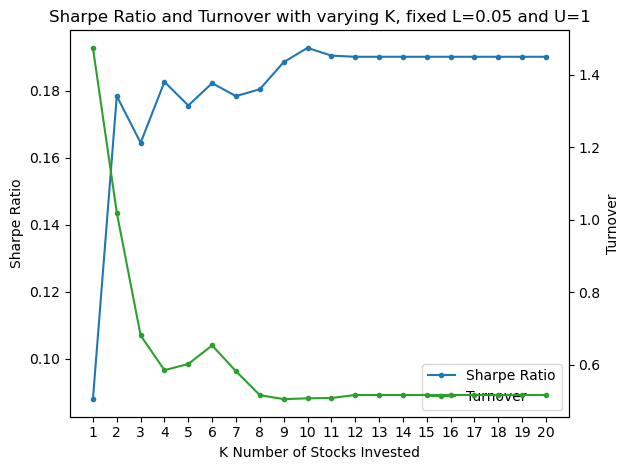

In [41]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

plt.title('Sharpe Ratio and Turnover with varying K, fixed L=0.05 and U=1')

ax1.plot(df['K'].values, df['Sharpe Ratio'].values, label='Sharpe Ratio', marker='.', color='tab:blue')
ax1.plot([], [], label='Turnover', marker='.', color='tab:green')
ax2.plot(df['K'].values, df['Turnover'].values, label='Turnover', marker='.', color='tab:green')
ax1.set_xlabel('K Number of Stocks Invested')
ax1.set_ylabel('Sharpe Ratio')
ax2.set_ylabel('Turnover')

ax1.legend()
plt.xticks(range(1, 21))
plt.tight_layout()
plt.show()